In [1]:
import sys
sys.path.append('/teamspace/studios/this_studio/up-detr')

In [7]:
import torch

# Define the Args class if it's necessary for your checkpoint
class Args:
    def __init__(self):
        self.num_classes = 2
        self.hidden_dim = 256
        # Add other relevant attributes as necessary

# Function to build the UPDETR model
def build_updetr(num_classes=2):
    from models.backbone import Backbone, Joiner
    from models.position_encoding import PositionEmbeddingSine
    from models.transformer import Transformer
    from models.updetr import UPDETR

    hidden_dim = 256
    backbone = Backbone("resnet50", train_backbone=False, return_interm_layers=False, dilation=False)
    pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
    backbone_with_pos_enc = Joiner(backbone, pos_enc)
    backbone_with_pos_enc.num_channels = backbone.num_channels
    transformer = Transformer(d_model=hidden_dim, normalize_before=True, return_intermediate_dec=True)

    model = UPDETR(
        backbone_with_pos_enc,
        transformer,
        num_classes=num_classes,
        num_queries=100,
        num_patches=10,
        feature_recon=False,
        query_shuffle=False
    )
    return model

# Initialize the model
model = build_updetr()

# Load the checkpoint with error handling
try:
    checkpoint_path = '/teamspace/studios/this_studio/up-detr/output/checkpoint.pth'
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Check if 'model' key exists in the checkpoint
    if 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'], strict=False)
    else:
        raise KeyError("Key 'model' not found in checkpoint.")
    
    print("Checkpoint loaded successfully!")
except KeyError as ke:
    print(f"Key error: {ke}")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

# Set the model to evaluation mode
model.eval()
print("Model is set to evaluation mode.")


Checkpoint loaded successfully!
Model is set to evaluation mode.


In [8]:
import matplotlib.pyplot as plt
# standard PyTorch mean-std input image normalization
image_transform = T.Compose([
    T.Resize(420),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
patch_aug_transform = T.Compose([
    T.RandomApply([
      T.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    T.RandomGrayscale(p=0.2),
])
patch_transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    patch_id = 0
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'patch_{patch_id}: {p[cl]:0.2f}'
        patch_id += 1
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

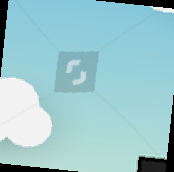

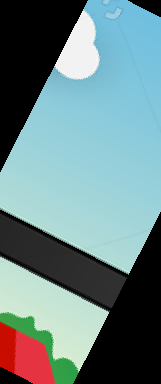

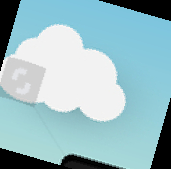

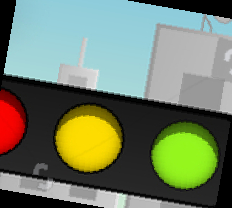

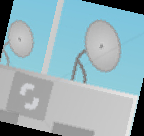

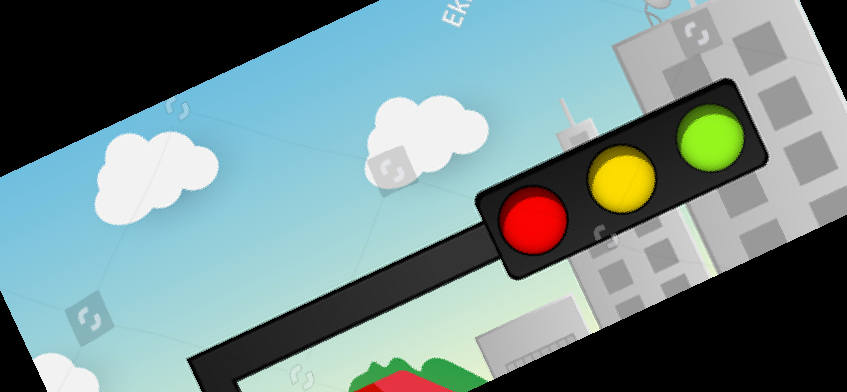

In [12]:
from PIL import Image
import random

# Set the random seed for reproducibility
random.seed(23333)

# Load the image from a local file path
url = '/teamspace/studios/this_studio/up-detr/stock-vector-cars-are-waiting-for-traffic-lights-in-the-city-concepts-drive-safely-warning-vector-1139559626.jpg'
image = Image.open(url)

patches = []

# Manually crop some reasonable objects
patches = [
    image.crop((19, 112, 193, 284)),
    image.crop((238, 19, 399, 403)),
    image.crop((408, 80, 579, 249)),
    image.crop((540, 141, 772, 349)),
    image.crop((728, 78, 872, 214)),
    image.crop((25, 19, 872, 411))
]

# Define your data augmentation function
def patch_aug_transform(patch):
    # Example augmentation: you can modify this to your needs
    # For instance, apply a random rotation
    angle = random.randint(-30, 30)  # Random rotation between -30 and 30 degrees
    return patch.rotate(angle)

# Apply data augmentations to the cropped patches
augmented_patches = [patch_aug_transform(patch) for patch in patches]

# Optionally, save or display the augmented patches
for i, patch in enumerate(augmented_patches):
    patch.show(title=f'Augmented Patch {i+1}')  # Display each augmented patch
    # Or save the patches
    # patch.save(f'augmented_patch_{i+1}.jpg')


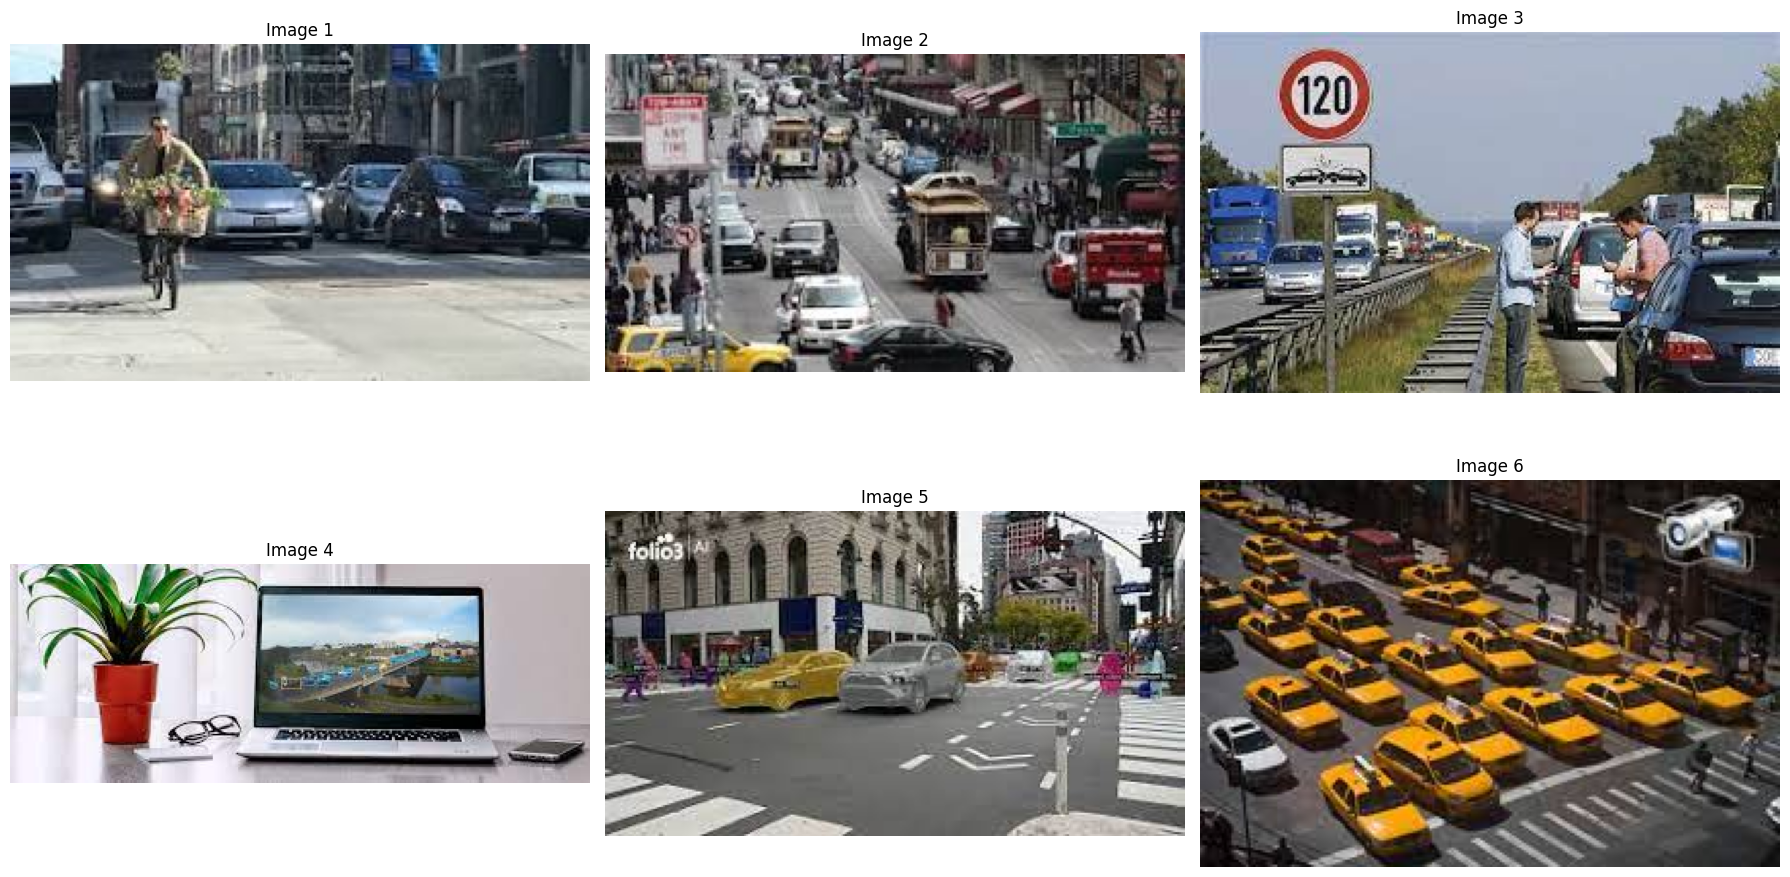

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load your images
image1 = mpimg.imread('/teamspace/studios/this_studio/test1.jpeg')  # Replace with your file paths
image2 = mpimg.imread('/teamspace/studios/this_studio/test2.jpeg')
image3 = mpimg.imread('/teamspace/studios/this_studio/test3.jpeg')
image4 = mpimg.imread('/teamspace/studios/this_studio/test4.jpeg')
image5 = mpimg.imread('/teamspace/studios/this_studio/test5.jpeg')
image6 = mpimg.imread('/teamspace/studios/this_studio/test6.jpeg')
# Create a horizontal plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Display each image in a subplot
axes[0, 0].imshow(image1)
axes[0, 0].axis('off')  # Hide axes
axes[0, 0].set_title('Image 1')  # Optional title

axes[0, 1].imshow(image2)
axes[0, 1].axis('off')
axes[0, 1].set_title('Image 2')

axes[0, 2].imshow(image3)
axes[0, 2].axis('off')
axes[0, 2].set_title('Image 3')

axes[1, 0].imshow(image4)
axes[1, 0].axis('off')
axes[1, 0].set_title('Image 4')

axes[1, 1].imshow(image5)
axes[1, 1].axis('off')
axes[1, 1].set_title('Image 5')

axes[1, 2].imshow(image6)
axes[1, 2].axis('off')
axes[1, 2].set_title('Image 6')

plt.tight_layout()
plt.show()

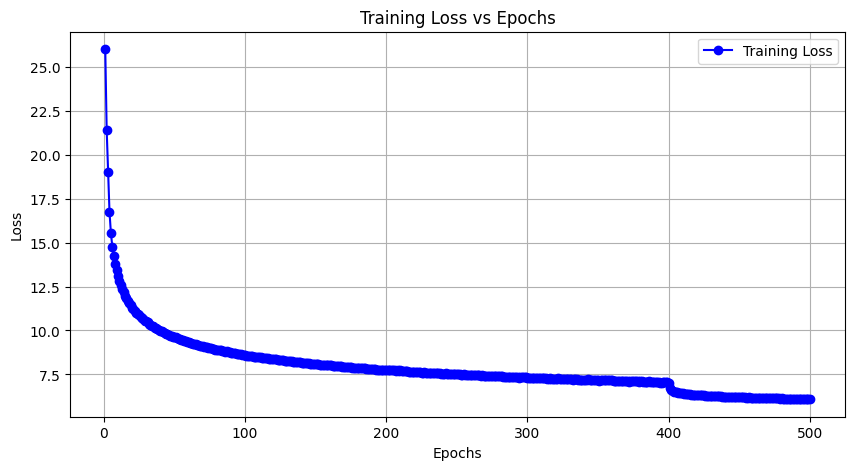

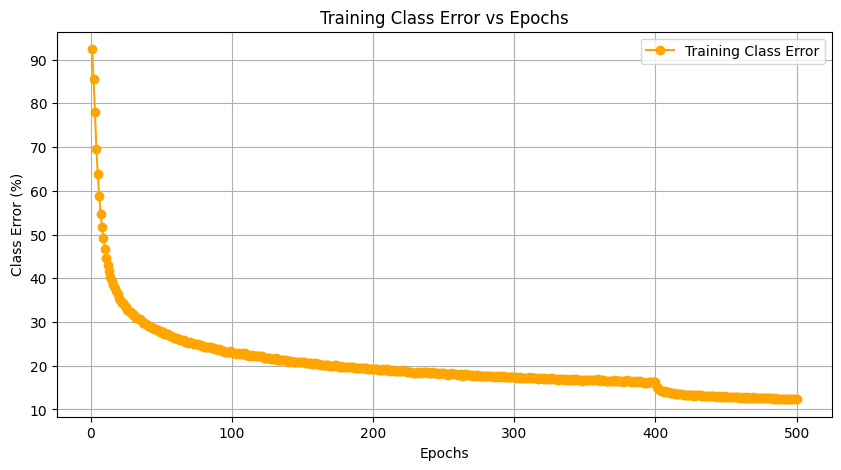

In [6]:
import matplotlib.pyplot as plt
import json
from pathlib import Path

def plot_metrics(log_file, output_dir):
    # Initialize lists to hold values for plotting
    epochs = []
    train_losses = []
    train_class_errors = []

    # Read the log file and extract metrics
    with open(log_file, 'r') as f:
        for line in f:
            stats = json.loads(line)
            epochs.append(stats.get('epoch', len(epochs) + 1))  # Default to sequential index if 'epoch' is missing
            train_losses.append(stats.get('train_loss', None))  # Adjust key based on your log structure
            train_class_errors.append(stats.get('train_class_error', None))  # Adjust key if needed

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')
    plt.legend()
    plt.grid()
    plt.savefig(f"{output_dir}/training_loss.png")
    plt.show()

    # Plot training class error
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_class_errors, label='Training Class Error', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Class Error (%)')
    plt.title('Training Class Error vs Epochs')
    plt.legend()
    plt.grid()
    plt.savefig(f"{output_dir}/training_class_error.png")
    plt.show()

# Specify the path to your output directory
output_dir = '/teamspace/studios/this_studio/up-detr/output'  # Update with your actual output directory path

# Define log file path and call the plot function
log_file = Path(output_dir) / "log1.txt"
plot_metrics(log_file, output_dir)


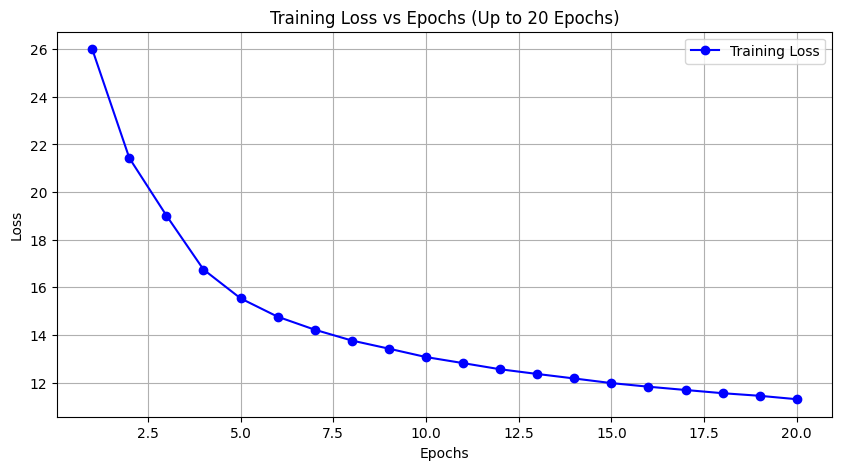

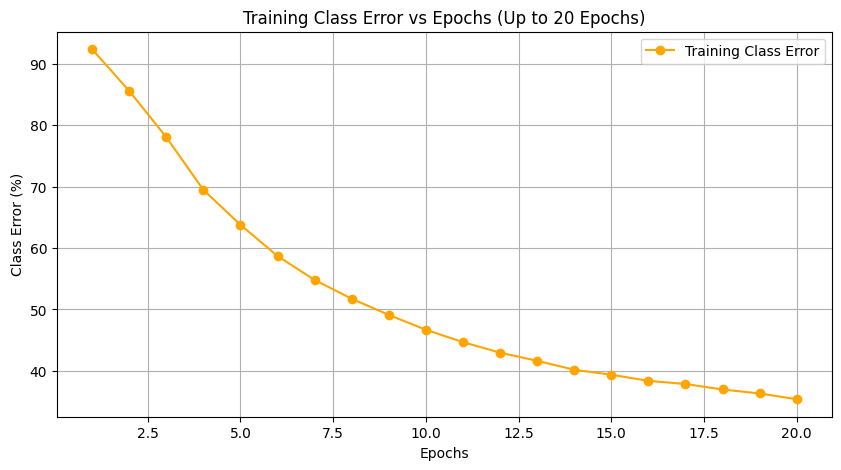

In [7]:
import matplotlib.pyplot as plt
import json
from pathlib import Path

def plot_metrics(log_file, output_dir, total_epochs=20):
    # Initialize lists to hold values for plotting
    epochs = []
    train_losses = []
    train_class_errors = []

    # Read the log file and extract metrics
    with open(log_file, 'r') as f:
        for line in f:
            stats = json.loads(line)
            epoch = stats.get('epoch', len(epochs) + 1)  # Default to sequential index if 'epoch' is missing
            if epoch > total_epochs:
                break
            epochs.append(epoch)
            train_losses.append(stats.get('train_loss', None))  # Adjust key based on your log structure
            train_class_errors.append(stats.get('train_class_error', None))  # Adjust key if needed

    # Ensure data is for all epochs up to `total_epochs`
    epochs = list(range(1, total_epochs + 1))
    train_losses += [None] * (total_epochs - len(train_losses))
    train_class_errors += [None] * (total_epochs - len(train_class_errors))

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs (Up to 20 Epochs)')
    plt.legend()
    plt.grid()
    plt.savefig(f"{output_dir}/training_loss.png")
    plt.show()

    # Plot training class error
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_class_errors, label='Training Class Error', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Class Error (%)')
    plt.title('Training Class Error vs Epochs (Up to 20 Epochs)')
    plt.legend()
    plt.grid()
    plt.savefig(f"{output_dir}/training_class_error.png")
    plt.show()

# Specify the path to your output directory
output_dir = '/teamspace/studios/this_studio/up-detr/output'  # Update with your actual output directory path

# Define log file path and call the plot function
log_file = Path(output_dir) / "log1.txt"
plot_metrics(log_file, output_dir, total_epochs=20)
